# NEURAL NETWORKS AND DEEP LEARNING FINAL PROJECT

### TEAM MEMBERS : AKSHITHA BAIRA, VIHAS ADI, NAVEEN KUMAR CHEKURI

### Semantic Segmentation of Brain Tumors in MRI Scans using Deep Learning Architectures

In [1]:
# Import the required libraries 
import os
import random
from shutil import copyfile
from torch.utils.data import Dataset
from PIL import Image
import torchvision.transforms as transforms
import os
import torch
import torch.nn as nn
import torch
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import torchvision.models.segmentation as models

In [1]:
# Set seed 
random.seed(42)

# Set the dataset path
image_dir = "/kaggle/input/final-project/data/data/images"
mask_dir = "/kaggle/input/final-project/data/data/masks"

# Output path
base_output = "/kaggle/working/split_data"
splits = ["train", "val", "test"]

# Creating the output folders
for split in splits:
    os.makedirs(f"{base_output}/{split}/images", exist_ok=True)
    os.makedirs(f"{base_output}/{split}/masks", exist_ok=True)


filenames = sorted(os.listdir(image_dir))
random.shuffle(filenames)

# Split
n_total = len(filenames)
n_train = int(0.8 * n_total)
n_val = int(0.1 * n_total)

train_files = filenames[:n_train]
val_files = filenames[n_train:n_train + n_val]
test_files = filenames[n_train + n_val:]

# Function to copy image-mask pairs
def copy_pairs(file_list, split):
    for fname in file_list:
        copyfile(os.path.join(image_dir, fname), f"{base_output}/{split}/images/{fname}")
        copyfile(os.path.join(mask_dir, fname), f"{base_output}/{split}/masks/{fname}")

# Copy files
copy_pairs(train_files, "train")
copy_pairs(val_files, "val")
copy_pairs(test_files, "test")

In [2]:
# Dataset Class
class BrainTumorDataset(Dataset):
    def __init__(self, image_dir, mask_dir, transform=None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.transform = transform
        self.image_filenames = sorted(os.listdir(image_dir))

    def __len__(self):
        return len(self.image_filenames)

    def __getitem__(self, idx):
        img_name = self.image_filenames[idx]
        
        image_path = os.path.join(self.image_dir, img_name)
        mask_path = os.path.join(self.mask_dir, img_name)

        # Load image and mask
        image = Image.open(image_path).convert("RGB")
        mask = Image.open(mask_path).convert("L")  # single channel

        # Apply transforms (same for both if needed)
        if self.transform:
            image = self.transform(image)
            mask = self.transform(mask)

        return image, mask


In [3]:
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
])


## IMPLEMENTING U-NET MODEL

In [4]:
# U-NET MODEL
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DoubleConv, self).__init__()
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),

            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)

class UNet(nn.Module):
    def __init__(self, in_channels=3, out_channels=1):
        super(UNet, self).__init__()
        self.encoder1 = DoubleConv(in_channels, 64)
        self.pool1 = nn.MaxPool2d(2)
        self.encoder2 = DoubleConv(64, 128)
        self.pool2 = nn.MaxPool2d(2)
        self.encoder3 = DoubleConv(128, 256)
        self.pool3 = nn.MaxPool2d(2)
        self.encoder4 = DoubleConv(256, 512)
        self.pool4 = nn.MaxPool2d(2)

        self.bottleneck = DoubleConv(512, 1024)

        self.upconv4 = nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2)
        self.decoder4 = DoubleConv(1024, 512)
        self.upconv3 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.decoder3 = DoubleConv(512, 256)
        self.upconv2 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.decoder2 = DoubleConv(256, 128)
        self.upconv1 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.decoder1 = DoubleConv(128, 64)

        self.final_conv = nn.Conv2d(64, out_channels, kernel_size=1)

    def forward(self, x):
        enc1 = self.encoder1(x)
        enc2 = self.encoder2(self.pool1(enc1))
        enc3 = self.encoder3(self.pool2(enc2))
        enc4 = self.encoder4(self.pool3(enc3))

        bottleneck = self.bottleneck(self.pool4(enc4))

        dec4 = self.upconv4(bottleneck)
        dec4 = self.decoder4(torch.cat([dec4, enc4], dim=1))
        dec3 = self.upconv3(dec4)
        dec3 = self.decoder3(torch.cat([dec3, enc3], dim=1))
        dec2 = self.upconv2(dec3)
        dec2 = self.decoder2(torch.cat([dec2, enc2], dim=1))
        dec1 = self.upconv1(dec2)
        dec1 = self.decoder1(torch.cat([dec1, enc1], dim=1))

        return self.final_conv(dec1)


In [5]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [6]:
# Redefine the transform 
import torchvision.transforms as transforms

transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
])

# Now create the datasets
train_dataset = BrainTumorDataset(
    image_dir="/kaggle/working/split_data/train/images",
    mask_dir="/kaggle/working/split_data/train/masks",
    transform=transform
)

val_dataset = BrainTumorDataset(
    image_dir="/kaggle/working/split_data/val/images",
    mask_dir="/kaggle/working/split_data/val/masks",
    transform=transform
)


In [7]:
# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False)


In [8]:
# Dice Loss function
class DiceLoss(nn.Module):
    def __init__(self, smooth=1.0):
        super(DiceLoss, self).__init__()
        self.smooth = smooth

    def forward(self, preds, targets):
        preds = torch.sigmoid(preds)  # Apply sigmoid
        preds = preds.view(-1)
        targets = targets.view(-1)
        intersection = (preds * targets).sum()
        dice = (2. * intersection + self.smooth) / (preds.sum() + targets.sum() + self.smooth)
        return 1 - dice

# Combine BCE With Logits + Dice Loss
bce_loss = nn.BCEWithLogitsLoss()
dice_loss = DiceLoss()

def combined_loss(preds, targets):
    return bce_loss(preds, targets) + dice_loss(preds, targets)


In [9]:
# U-NET model training
def train_model(model, train_loader, val_loader, epochs=30, lr=1e-4):
    model.to(device)
    optimizer = optim.Adam(model.parameters(), lr=lr)

    for epoch in range(epochs):
        model.train()
        train_loss = 0.0

        for imgs, masks in train_loader:
            imgs = imgs.to(device)
            masks = masks.to(device)

            preds = model(imgs)
            loss = combined_loss(preds, masks)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            train_loss += loss.item()

        avg_train_loss = train_loss / len(train_loader)

        # Validation
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for imgs, masks in val_loader:
                imgs = imgs.to(device)
                masks = masks.to(device)
                preds = model(imgs)
                loss = combined_loss(preds, masks)
                val_loss += loss.item()

        avg_val_loss = val_loss / len(val_loader)

        print(f"Epoch {epoch+1}/{epochs} | Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f}")

    print(" Training complete.")


In [10]:
model = UNet(in_channels=3, out_channels=1)
train_model(model, train_loader, val_loader, epochs=30)

Epoch 1/30 | Train Loss: 1.1814 | Val Loss: 1.0220
Epoch 2/30 | Train Loss: 0.8829 | Val Loss: 0.7641
Epoch 3/30 | Train Loss: 0.6326 | Val Loss: 0.6047
Epoch 4/30 | Train Loss: 0.4560 | Val Loss: 0.4448
Epoch 5/30 | Train Loss: 0.3774 | Val Loss: 0.3691
Epoch 6/30 | Train Loss: 0.3310 | Val Loss: 0.3226
Epoch 7/30 | Train Loss: 0.2985 | Val Loss: 0.3097
Epoch 8/30 | Train Loss: 0.2799 | Val Loss: 0.3164
Epoch 9/30 | Train Loss: 0.2609 | Val Loss: 0.3012
Epoch 10/30 | Train Loss: 0.2534 | Val Loss: 0.3084
Epoch 11/30 | Train Loss: 0.2351 | Val Loss: 0.2931
Epoch 12/30 | Train Loss: 0.2258 | Val Loss: 0.2680
Epoch 13/30 | Train Loss: 0.2112 | Val Loss: 0.2887
Epoch 14/30 | Train Loss: 0.2130 | Val Loss: 0.2724
Epoch 15/30 | Train Loss: 0.1981 | Val Loss: 0.2948
Epoch 16/30 | Train Loss: 0.2016 | Val Loss: 0.2741
Epoch 17/30 | Train Loss: 0.1879 | Val Loss: 0.2486
Epoch 18/30 | Train Loss: 0.1852 | Val Loss: 0.2445
Epoch 19/30 | Train Loss: 0.1769 | Val Loss: 0.2857
Epoch 20/30 | Train L

In [11]:
 test_dataset = BrainTumorDataset(
    image_dir="/kaggle/working/split_data/test/images",
    mask_dir="/kaggle/working/split_data/test/masks",
    transform=transform
)

test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)


In [12]:
def evaluate_model(model, test_loader):
    model.eval()
    model.to(device)  

    dice_scores = []
    iou_scores = []
    pixel_accuracies = []

    with torch.no_grad():
        for imgs, masks in test_loader:
            imgs = imgs.to(device)
            masks = masks.to(device)

            output = model(imgs)
            preds = output['out'] if isinstance(output, dict) else output
            preds = torch.sigmoid(preds)
            preds = (preds > 0.5).float()


            # Flatten
            preds_flat = preds.view(-1)
            masks_flat = masks.view(-1)

            # Dice Score
            intersection = (preds_flat * masks_flat).sum()
            dice = (2. * intersection) / (preds_flat.sum() + masks_flat.sum() + 1e-8)
            dice_scores.append(dice.item())

            # IoU
            union = (preds_flat + masks_flat).clamp(0, 1).sum()
            iou = intersection / (union + 1e-8)
            iou_scores.append(iou.item())

            # Pixel Accuracy
            correct = (preds_flat == masks_flat).sum()
            pixel_accuracy = correct.float() / len(preds_flat)
            pixel_accuracies.append(pixel_accuracy.item())

    print(f"\n Evaluation Results:")
    print(f"Avg Dice Score     : {sum(dice_scores)/len(dice_scores):.4f}")
    print(f"Avg IoU            : {sum(iou_scores)/len(iou_scores):.4f}")
    print(f"Avg Pixel Accuracy : {sum(pixel_accuracies)/len(pixel_accuracies):.4f}")


In [13]:
import matplotlib.pyplot as plt

def visualize_predictions(model, dataset, num_samples=3):
    model.eval()
    model.to(device)

    for i in range(num_samples):
        img, mask = dataset[i]
        img_input = img.unsqueeze(0).to(device)

        with torch.no_grad():
            pred = model(img_input)
            pred = torch.sigmoid(pred)
            pred = (pred > 0.5).float()

        # Move to CPU for plotting
        img_np = img.permute(1, 2, 0).cpu().numpy()
        mask_np = mask.squeeze().cpu().numpy()
        pred_np = pred.squeeze().cpu().numpy()

        plt.figure(figsize=(12, 4))
        plt.subplot(1, 3, 1)
        plt.imshow(img_np)
        plt.title("MRI Image")

        plt.subplot(1, 3, 2)
        plt.imshow(mask_np, cmap='gray')
        plt.title("Ground Truth")

        plt.subplot(1, 3, 3)
        plt.imshow(pred_np, cmap='gray')
        plt.title("Prediction")

        plt.show()



 Evaluation Results:
Avg Dice Score     : 0.6696
Avg IoU            : 0.5880
Avg Pixel Accuracy : 0.9914


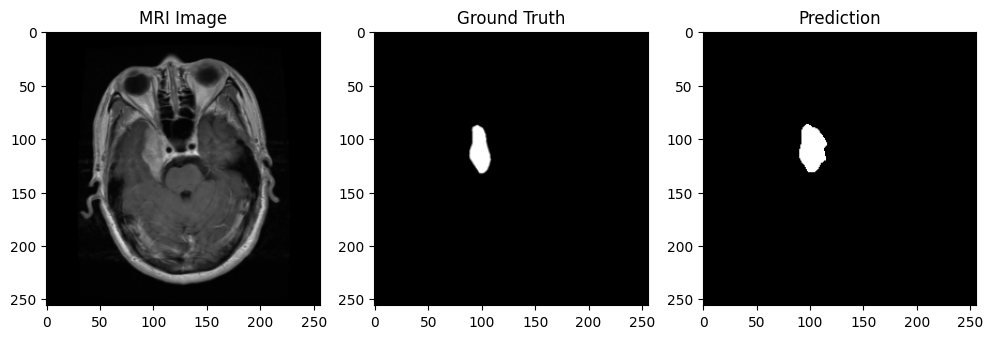

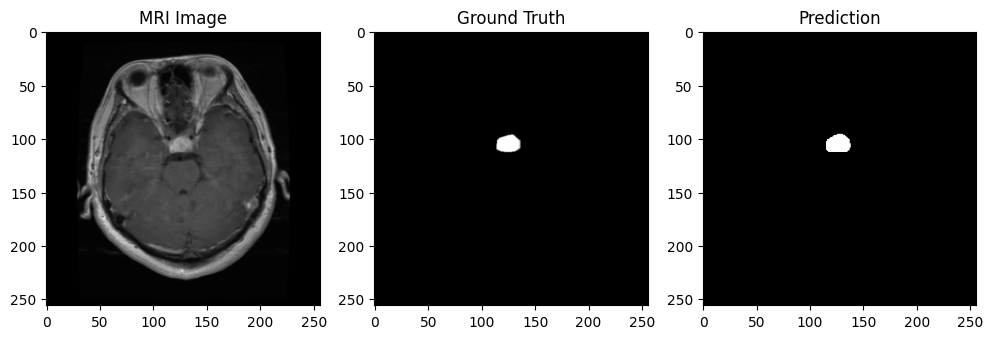

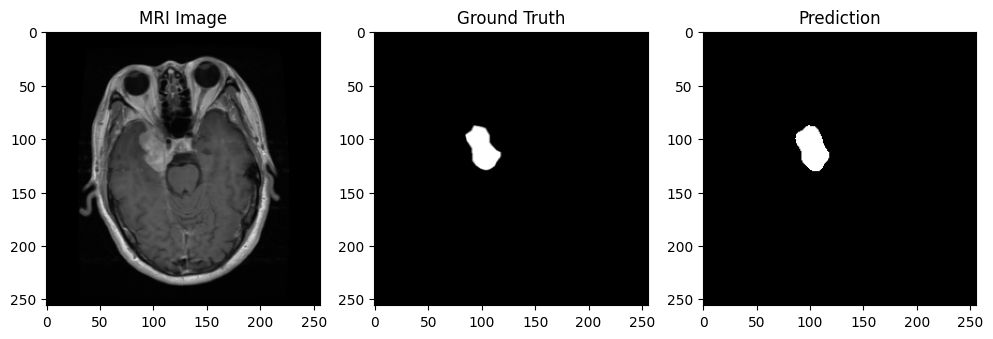

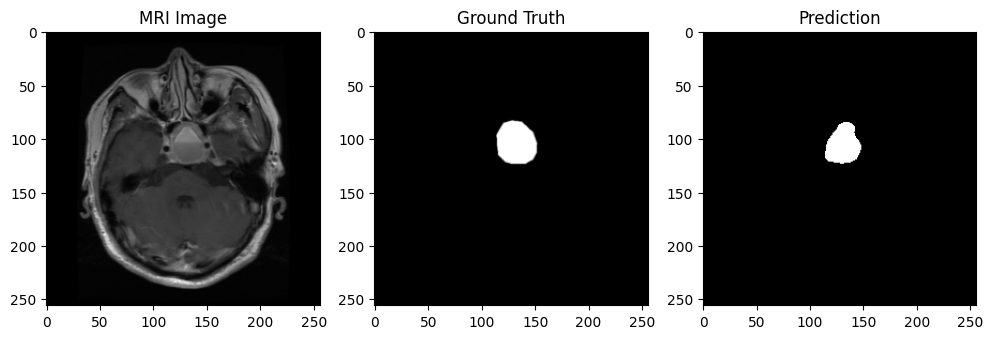

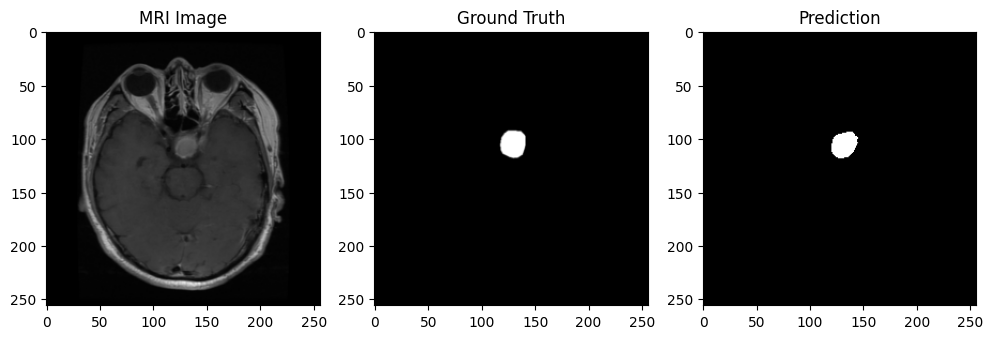

In [14]:
evaluate_model(model, test_loader)
visualize_predictions(model, test_dataset, num_samples=5)



## IMPLEMENTING ATTENTION U-NET MODEL

In [15]:
#ATTENTION U-NET MODEL
class AttentionBlock(nn.Module):
    def __init__(self, F_g, F_l, F_int):
        super(AttentionBlock, self).__init__()
        self.W_g = nn.Sequential(
            nn.Conv2d(F_g, F_int, kernel_size=1, stride=1, padding=0),
            nn.BatchNorm2d(F_int)
        )

        self.W_x = nn.Sequential(
            nn.Conv2d(F_l, F_int, kernel_size=1, stride=1, padding=0),
            nn.BatchNorm2d(F_int)
        )

        self.psi = nn.Sequential(
            nn.Conv2d(F_int, 1, kernel_size=1, stride=1, padding=0),
            nn.BatchNorm2d(1),
            nn.Sigmoid()
        )

        self.relu = nn.ReLU(inplace=True)

    def forward(self, g, x):
        g1 = self.W_g(g)
        x1 = self.W_x(x)
        psi = self.relu(g1 + x1)
        psi = self.psi(psi)
        return x * psi


class AttentionUNet(nn.Module):
    def __init__(self, in_channels=3, out_channels=1):
        super(AttentionUNet, self).__init__()
        self.encoder1 = DoubleConv(in_channels, 64)
        self.pool1 = nn.MaxPool2d(2)
        self.encoder2 = DoubleConv(64, 128)
        self.pool2 = nn.MaxPool2d(2)
        self.encoder3 = DoubleConv(128, 256)
        self.pool3 = nn.MaxPool2d(2)
        self.encoder4 = DoubleConv(256, 512)
        self.pool4 = nn.MaxPool2d(2)

        self.bottleneck = DoubleConv(512, 1024)

        self.upconv4 = nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2)
        self.att4 = AttentionBlock(F_g=512, F_l=512, F_int=256)
        self.decoder4 = DoubleConv(1024, 512)

        self.upconv3 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.att3 = AttentionBlock(F_g=256, F_l=256, F_int=128)
        self.decoder3 = DoubleConv(512, 256)

        self.upconv2 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.att2 = AttentionBlock(F_g=128, F_l=128, F_int=64)
        self.decoder2 = DoubleConv(256, 128)

        self.upconv1 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.att1 = AttentionBlock(F_g=64, F_l=64, F_int=32)
        self.decoder1 = DoubleConv(128, 64)

        self.final_conv = nn.Conv2d(64, out_channels, kernel_size=1)

    def forward(self, x):
        enc1 = self.encoder1(x)
        enc2 = self.encoder2(self.pool1(enc1))
        enc3 = self.encoder3(self.pool2(enc2))
        enc4 = self.encoder4(self.pool3(enc3))

        bottleneck = self.bottleneck(self.pool4(enc4))

        up4 = self.upconv4(bottleneck)
        att4 = self.att4(g=up4, x=enc4)
        dec4 = self.decoder4(torch.cat([up4, att4], dim=1))

        up3 = self.upconv3(dec4)
        att3 = self.att3(g=up3, x=enc3)
        dec3 = self.decoder3(torch.cat([up3, att3], dim=1))

        up2 = self.upconv2(dec3)
        att2 = self.att2(g=up2, x=enc2)
        dec2 = self.decoder2(torch.cat([up2, att2], dim=1))

        up1 = self.upconv1(dec2)
        att1 = self.att1(g=up1, x=enc1)
        dec1 = self.decoder1(torch.cat([up1, att1], dim=1))

        return self.final_conv(dec1)


In [17]:
#ATTENTION U-NET MODEL Training 
attn_model = AttentionUNet(in_channels=3, out_channels=1)
train_model(attn_model, train_loader, val_loader, epochs=30)
 

Epoch 1/30 | Train Loss: 1.1193 | Val Loss: 0.9817
Epoch 2/30 | Train Loss: 0.7993 | Val Loss: 0.7231
Epoch 3/30 | Train Loss: 0.5356 | Val Loss: 0.5313
Epoch 4/30 | Train Loss: 0.4084 | Val Loss: 0.3857
Epoch 5/30 | Train Loss: 0.3494 | Val Loss: 0.5059
Epoch 6/30 | Train Loss: 0.3110 | Val Loss: 0.3340
Epoch 7/30 | Train Loss: 0.2832 | Val Loss: 0.3262
Epoch 8/30 | Train Loss: 0.2788 | Val Loss: 0.3411
Epoch 9/30 | Train Loss: 0.2710 | Val Loss: 0.2999
Epoch 10/30 | Train Loss: 0.2340 | Val Loss: 0.2953
Epoch 11/30 | Train Loss: 0.2300 | Val Loss: 0.2745
Epoch 12/30 | Train Loss: 0.2179 | Val Loss: 0.2830
Epoch 13/30 | Train Loss: 0.2280 | Val Loss: 0.2778
Epoch 14/30 | Train Loss: 0.2051 | Val Loss: 0.2588
Epoch 15/30 | Train Loss: 0.1968 | Val Loss: 0.2836
Epoch 16/30 | Train Loss: 0.1898 | Val Loss: 0.2645
Epoch 17/30 | Train Loss: 0.1876 | Val Loss: 0.2568
Epoch 18/30 | Train Loss: 0.1773 | Val Loss: 0.2499
Epoch 19/30 | Train Loss: 0.1774 | Val Loss: 0.2729
Epoch 20/30 | Train L


 Evaluation Results:
Avg Dice Score     : 0.7222
Avg IoU            : 0.6411
Avg Pixel Accuracy : 0.9921


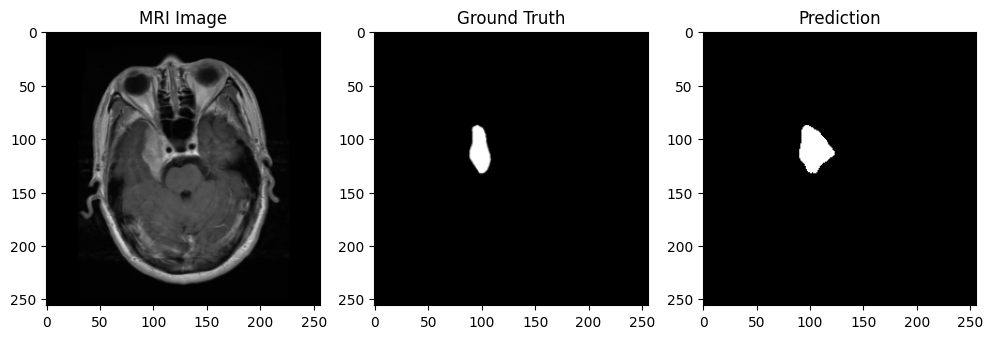

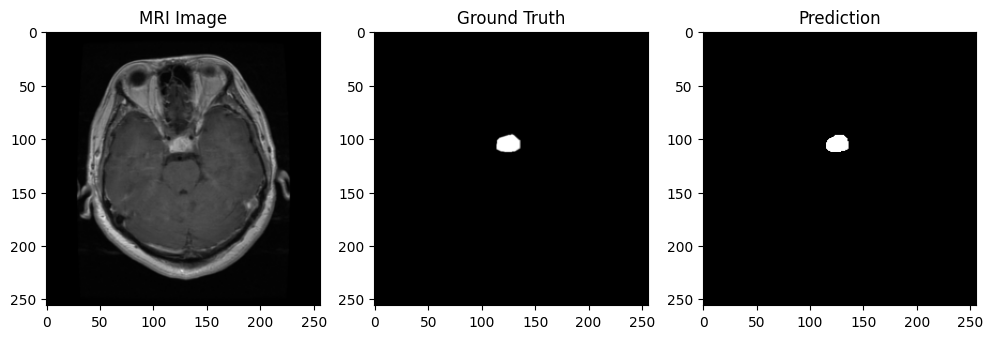

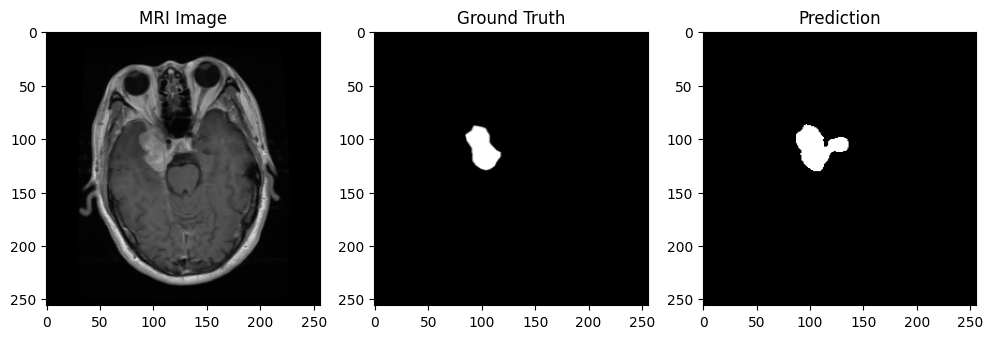

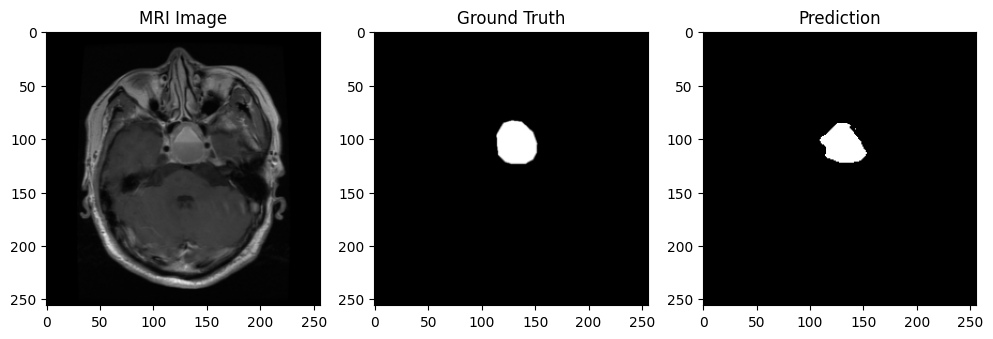

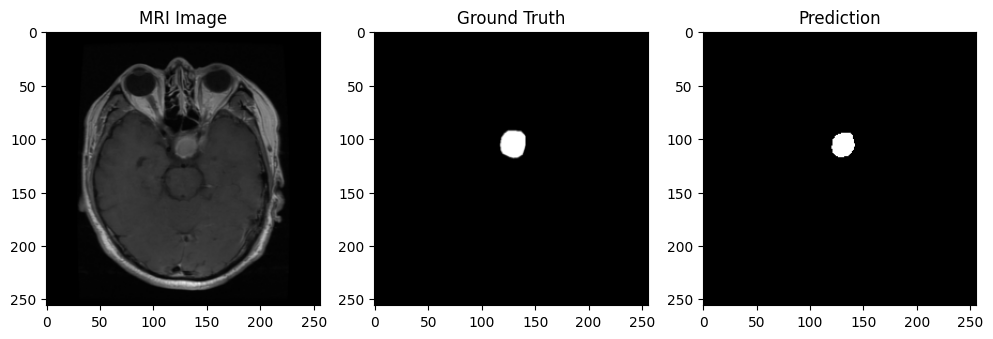

In [18]:
evaluate_model(attn_model, test_loader)
visualize_predictions(attn_model, test_dataset, num_samples=5)



In [19]:
torch.save(attn_model.state_dict(), "/kaggle/working/attention_unet.pth")
print(" Attention U-Net model saved.")


 Attention U-Net model saved.


## IMPLEMENTING FCN MODEL

In [20]:
import torchvision.models.segmentation as models

def get_fcn_model(num_classes=1):
    fcn = models.fcn_resnet50(pretrained=False)
    fcn.classifier[4] = nn.Conv2d(512, num_classes, kernel_size=1)
    return fcn


In [21]:
fcn_model = get_fcn_model()
fcn_model = fcn_model.to(device)

def train_fcn(model, train_loader, val_loader, epochs=10, lr=1e-4):
    optimizer = optim.Adam(model.parameters(), lr=lr)
    for epoch in range(epochs):
        model.train()
        total_loss = 0.0
        for imgs, masks in train_loader:
            imgs = imgs.to(device)
            masks = masks.to(device)

            optimizer.zero_grad()
            output = model(imgs)['out']
            loss = combined_loss(output, masks)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        print(f"[FCN] Epoch {epoch+1}/{epochs} | Loss: {total_loss/len(train_loader):.4f}")


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 155MB/s] 


In [22]:
train_fcn(fcn_model, train_loader, val_loader, epochs=30)


[FCN] Epoch 1/30 | Loss: 0.5502
[FCN] Epoch 2/30 | Loss: 0.2551
[FCN] Epoch 3/30 | Loss: 0.2100
[FCN] Epoch 4/30 | Loss: 0.1783
[FCN] Epoch 5/30 | Loss: 0.1596
[FCN] Epoch 6/30 | Loss: 0.1421
[FCN] Epoch 7/30 | Loss: 0.1395
[FCN] Epoch 8/30 | Loss: 0.1388
[FCN] Epoch 9/30 | Loss: 0.1145
[FCN] Epoch 10/30 | Loss: 0.1049
[FCN] Epoch 11/30 | Loss: 0.1041
[FCN] Epoch 12/30 | Loss: 0.0858
[FCN] Epoch 13/30 | Loss: 0.0773
[FCN] Epoch 14/30 | Loss: 0.0810
[FCN] Epoch 15/30 | Loss: 0.1257
[FCN] Epoch 16/30 | Loss: 0.0812
[FCN] Epoch 17/30 | Loss: 0.0656
[FCN] Epoch 18/30 | Loss: 0.0614
[FCN] Epoch 19/30 | Loss: 0.0558
[FCN] Epoch 20/30 | Loss: 0.0533
[FCN] Epoch 21/30 | Loss: 0.0853
[FCN] Epoch 22/30 | Loss: 0.0835
[FCN] Epoch 23/30 | Loss: 0.0690
[FCN] Epoch 24/30 | Loss: 0.0527
[FCN] Epoch 25/30 | Loss: 0.0466
[FCN] Epoch 26/30 | Loss: 0.0448
[FCN] Epoch 27/30 | Loss: 0.0455
[FCN] Epoch 28/30 | Loss: 0.0462
[FCN] Epoch 29/30 | Loss: 0.0481
[FCN] Epoch 30/30 | Loss: 0.0968


In [26]:
evaluate_model(fcn_model, test_loader)




 Evaluation Results:
Avg Dice Score     : 0.7536
Avg IoU            : 0.6589
Avg Pixel Accuracy : 0.9918


In [24]:
def visualize_predictions(model, dataset, num_samples=3):
    model.eval()
    model.to(device)

    for i in range(num_samples):
        img, mask = dataset[i]
        img_input = img.unsqueeze(0).to(device)

        with torch.no_grad():
            
            output = model(img_input)
            pred = output['out'] if isinstance(output, dict) else output

            pred = torch.sigmoid(pred)
            pred = (pred > 0.5).float()

        img_np = img.permute(1, 2, 0).cpu().numpy()
        mask_np = mask.squeeze().cpu().numpy()
        pred_np = pred.squeeze().cpu().numpy()

        plt.figure(figsize=(12, 4))
        plt.subplot(1, 3, 1)
        plt.imshow(img_np)
        plt.title("MRI Image")

        plt.subplot(1, 3, 2)
        plt.imshow(mask_np, cmap='gray')
        plt.title("Ground Truth")

        plt.subplot(1, 3, 3)
        plt.imshow(pred_np, cmap='gray')
        plt.title("Prediction")

        plt.show()


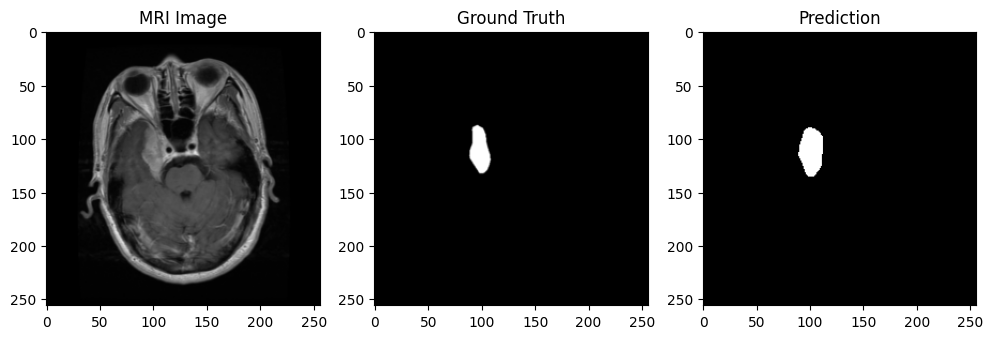

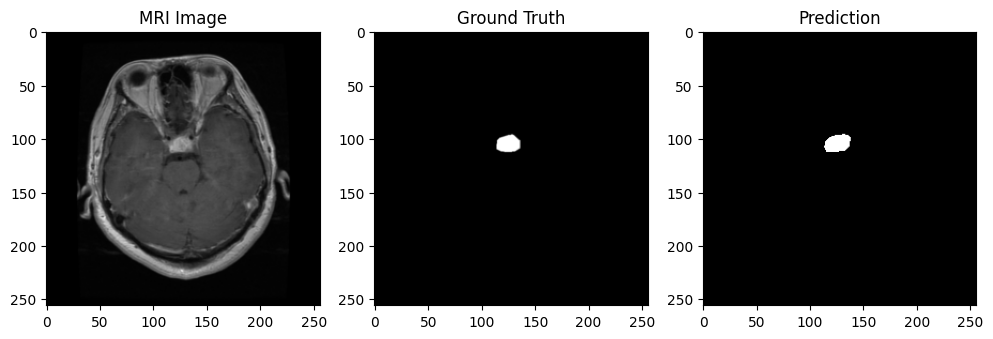

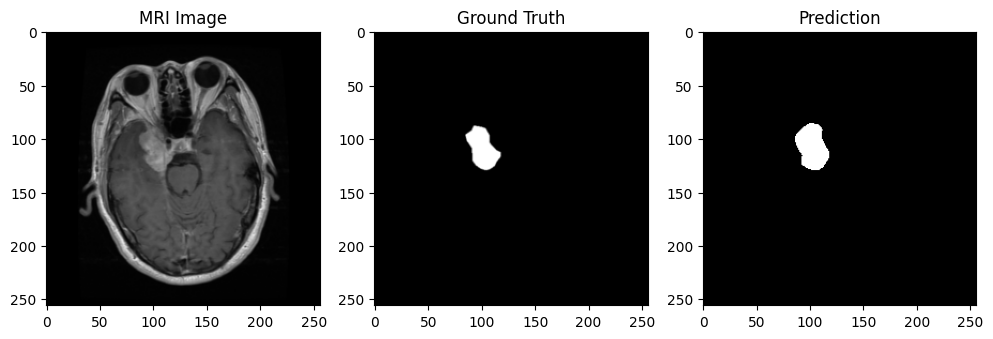

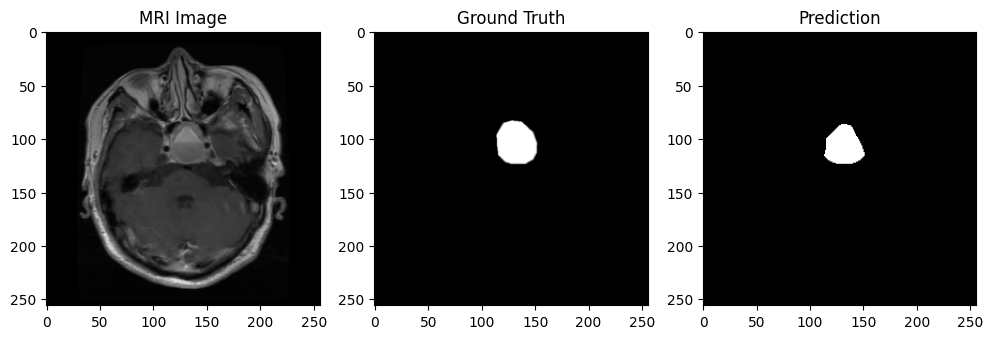

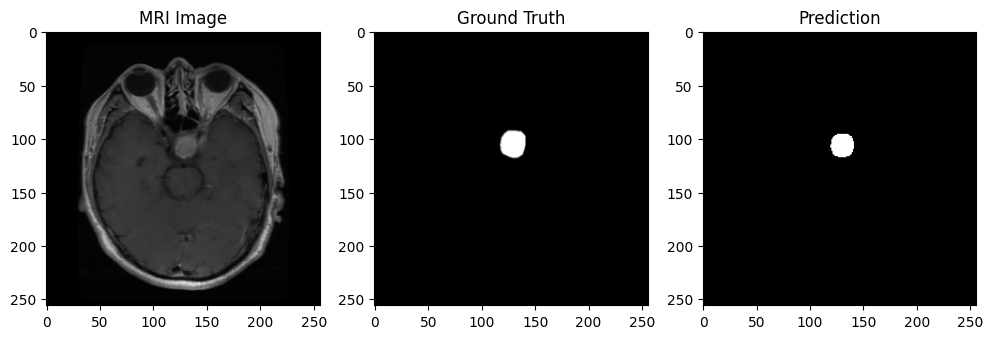

In [25]:
visualize_predictions(fcn_model, test_dataset, num_samples=5)


## IMPLEMENTING SEGNET MODEL 

In [27]:
#SEGNET MODEL
class SegNet(nn.Module):
    def __init__(self, in_channels=3, out_channels=1):
        super(SegNet, self).__init__()

        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(64, 128, 3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(128, 256, 3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),
        )

        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(256, 128, 2, stride=2),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),

            nn.ConvTranspose2d(128, 64, 2, stride=2),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),

            nn.ConvTranspose2d(64, 32, 2, stride=2),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),

            nn.Conv2d(32, out_channels, kernel_size=1)
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x


In [28]:
segnet_model = SegNet()
train_model(segnet_model, train_loader, val_loader, epochs=30)


Epoch 1/30 | Train Loss: 1.4318 | Val Loss: 1.2843
Epoch 2/30 | Train Loss: 1.2092 | Val Loss: 1.1381
Epoch 3/30 | Train Loss: 1.0875 | Val Loss: 1.0357
Epoch 4/30 | Train Loss: 0.9782 | Val Loss: 1.0066
Epoch 5/30 | Train Loss: 0.8825 | Val Loss: 0.8677
Epoch 6/30 | Train Loss: 0.8072 | Val Loss: 0.7990
Epoch 7/30 | Train Loss: 0.7496 | Val Loss: 0.7545
Epoch 8/30 | Train Loss: 0.7138 | Val Loss: 0.7241
Epoch 9/30 | Train Loss: 0.6869 | Val Loss: 0.8284
Epoch 10/30 | Train Loss: 0.6685 | Val Loss: 0.7305
Epoch 11/30 | Train Loss: 0.6564 | Val Loss: 0.7380
Epoch 12/30 | Train Loss: 0.6443 | Val Loss: 0.6861
Epoch 13/30 | Train Loss: 0.6355 | Val Loss: 0.7518
Epoch 14/30 | Train Loss: 0.6204 | Val Loss: 0.6838
Epoch 15/30 | Train Loss: 0.6180 | Val Loss: 0.8073
Epoch 16/30 | Train Loss: 0.6115 | Val Loss: 0.7297
Epoch 17/30 | Train Loss: 0.6073 | Val Loss: 0.7231
Epoch 18/30 | Train Loss: 0.5906 | Val Loss: 0.6592
Epoch 19/30 | Train Loss: 0.5926 | Val Loss: 0.6501
Epoch 20/30 | Train L


 Evaluation Results:
Avg Dice Score     : 0.4481
Avg IoU            : 0.3259
Avg Pixel Accuracy : 0.9817


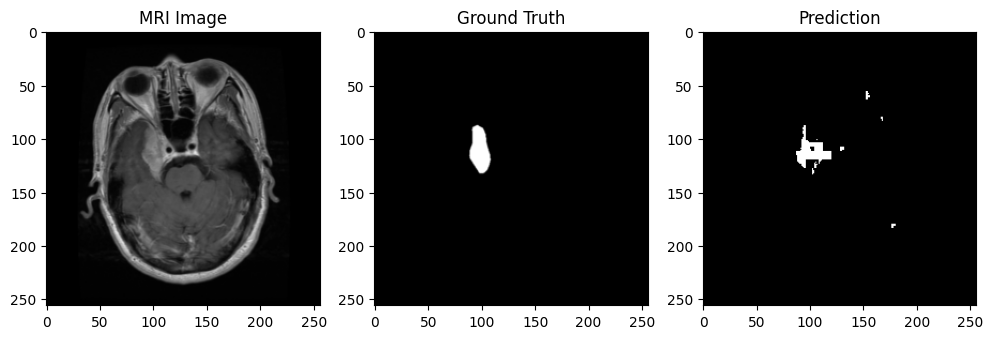

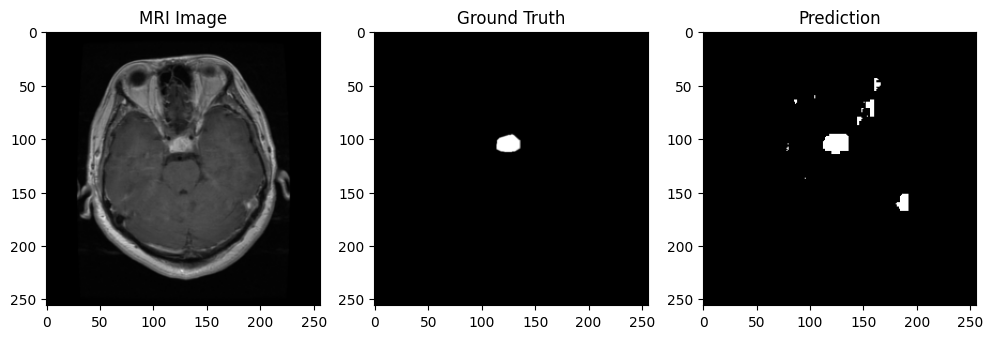

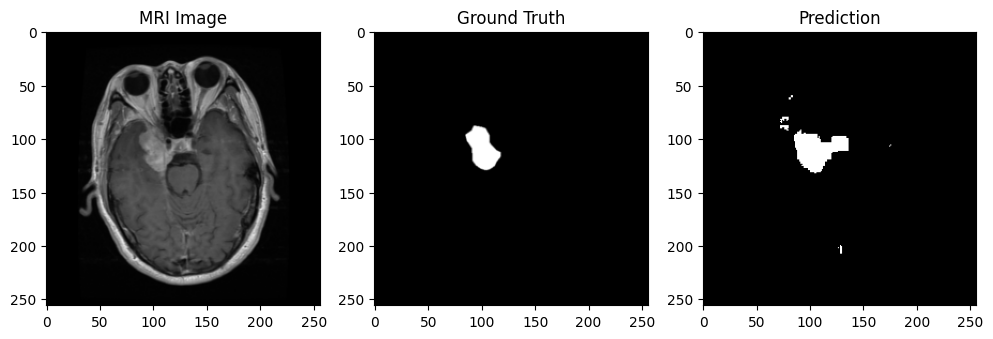

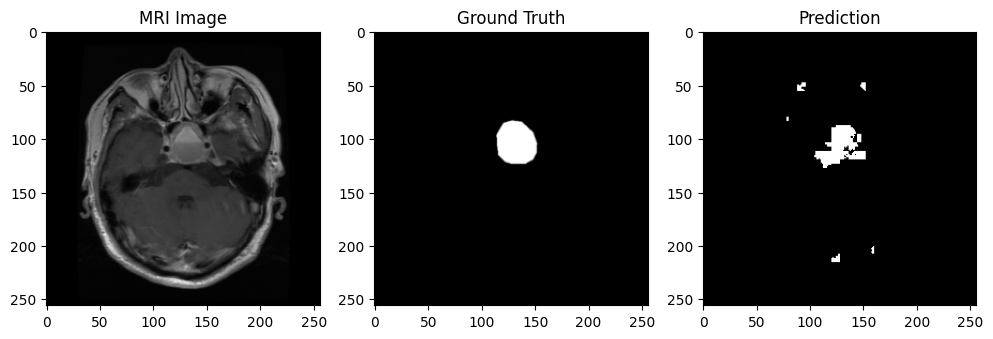

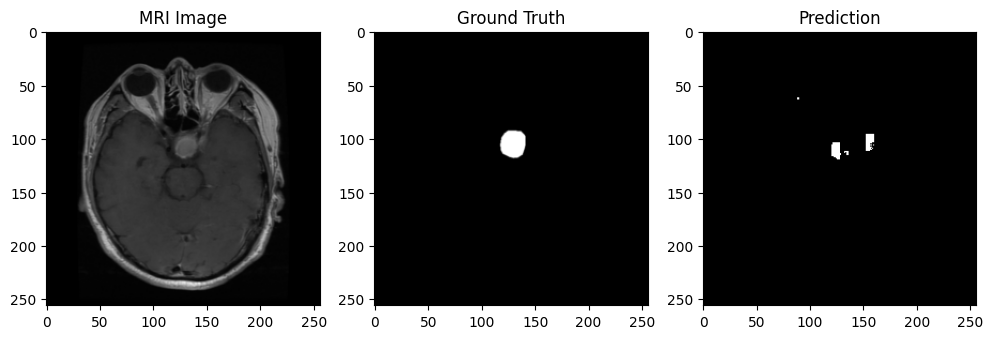

In [29]:
evaluate_model(segnet_model, test_loader)
visualize_predictions(segnet_model, test_dataset, num_samples=5)


In [31]:
import pandas as pd

# Results comparision 
results = {
    "Model": ["U-Net", "Attention U-Net", "FCN", "SegNet"],
    "Dice Score": [0.6696, 0.7222, 0.7536, 0.4481],
    "IoU": [0.5880, 0.6411, 0.6589, 0.3259],
    "Pixel Accuracy": [0.9914, 0.9921, 0.9918, 0.9817]
}

df = pd.DataFrame(results)
print("\n Final Model Comparison:")
display(df)



 Final Model Comparison:


,Model,Dice Score,IoU,Pixel Accuracy
0,U-Net,0.6696,0.5880,0.9914
1,Attention U-Net,0.7222,0.6411,0.9921
2,FCN,0.7536,0.6589,0.9918
3,SegNet,0.4481,0.3259,0.9817


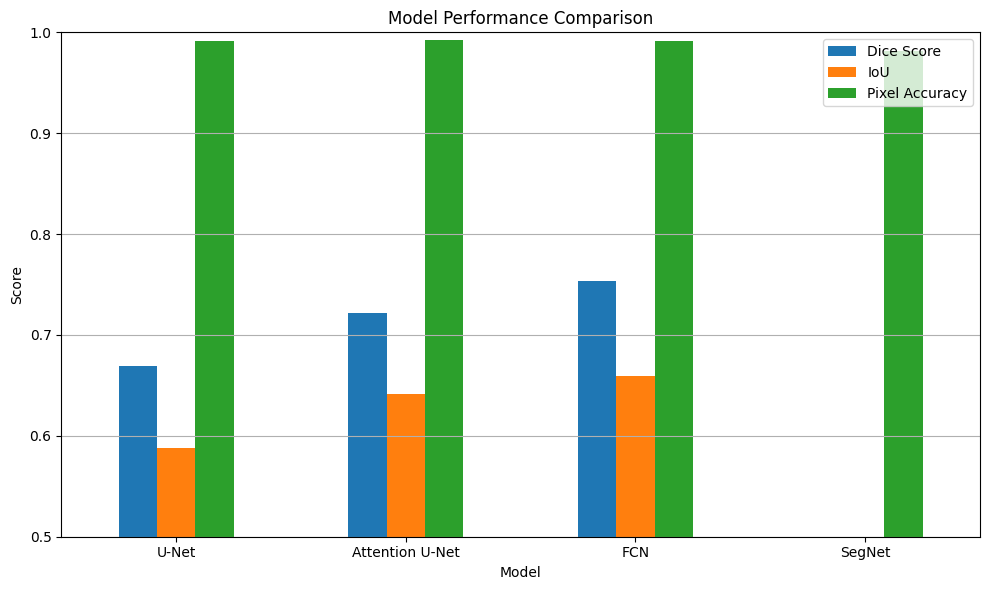

In [32]:
import matplotlib.pyplot as plt

def plot_metrics(df):
    df.set_index("Model")[["Dice Score", "IoU", "Pixel Accuracy"]].plot(
        kind="bar", figsize=(10, 6), ylim=(0.5, 1.0), rot=0
    )
    plt.title("Model Performance Comparison")
    plt.ylabel("Score")
    plt.grid(axis='y')
    plt.tight_layout()
    plt.show()

plot_metrics(df)


### RESEARCH GATE LINK

https://www.researchgate.net/publication/391705280_Semantic_Segmentation_of_Brain_Tumors_in_MRI_Scans_using_Deep_Learning_Architectures